In [394]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 60% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
#import importlib
import sys
sys.path.append('./helpers/')

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

# Summary

## The protocol

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
        * used hierarchical correlation dropper
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed

5. Modeling

6. Evaluate errors

7. Feature importance

## Current TODOs

0. Priorities
   1. $\checkmark$ ~~Remove the target feature for the pipeline?~~
        * if the pipeline is fit for the independent features, then it should work with them alone;
        * whatever preprocessing is needed for the target feature can be done independently, outside of the pipeline 
   
1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
    
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~

3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?

4. More EDA
    * Identify quantities to be removed:
        * $\checkmark$ ~~IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution~~ $\to$ _this led to a big step in improvement_
            * ~~or see if they're correlated with another feature, like 'sub_area'~~ $\to$ did not find this; just removed sampled IDs
            * **open** 
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 

5. More feature engineering
    * There are a few more things which can be done to see if there's an improvement:
        * $\checkmark$ ~~removing some IDs (rows) which have some outlier behavior (clearly defined spikes in distributions)~~
        * aggregating some features together (e.g. combining nearby 'sub_areas') $\to$ needs some ad hoc investigations
        * $\checkmark$ Using the classifiers to identify and reduce the number of features to only the important ones. $\to$ _no improvement; slightly worse with XGB_
            * $\checkmark$ removed the 'sub_area' feature entirely $\to$ _no improvement_
            * **TODO** try with other classifiers

6. Try to package up the routine into a single stage with a multistep pipeline
    * The issue is employing the KNN_imputer
        * the issue _was_ keeping track of the columns since the stages work on different subsets;
    * An idea would be to
        1. Order the columns first by datatype
        2. Then do the structure-preserving transformations (transformations which preserve the number of columns) like scaling, ordinal encoding, imputing(?))
        3. Then do the transformations like OneHotEnc 
    * **Notes**
        * since ther original plan was to use the KNN-imputer, where all features were needed together, this meant
            1. process the num. and cat. features separately
            2. re-attach columns and re-cast dtypes
            3. apply the KNN-imputer
    * **IDEA** to generalize, need a flexible pipeline 
        * `overall_pipeline([sub_pipeline1(data_subsetA, data_subsetB, data_subsetC), sub_pipeline2(data_subsetA, data_subset_rest),...])`
        * the problem is keeping track of the columns since after the first subpipeline, they will be lost.
  

## Additional notes
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

# Modeling

In [7]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

## Load the data

In [8]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train_prepro.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [10]:
X = df.drop(["id", "price_doc_", "price_doc", "timestamp"], axis=1)
y = df[["price_doc_"]].copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.25)

### Grid Search

In [12]:
#metric = 'neg_mean_squared_log_error'
metric = 'neg_mean_squared_error'

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<hr style="border: 4px dashed #000000; border-style: none none dashed; color: #fff; background-color: #fff; height: 4.0px;"/>

## Training and validation



## NOTES

1. ~~there is a discrepancy between TTS and KFold validated estimators $\to$ which to trust?~~ problem: using training data as test data in TTS
2. The params used in one cross_val object are different from another?

### TODO

1. $\checkmark$ ~~Better data-splitting:~~
    1. Split the data into test, train sets
    2. take the Train set, and then do the CV _only_ on it. 
    3. then use the test set to eval the model

<hr style="border: 4px dashed red; border-style: none none dotted; color: #fffff; background-color: white; height: 4.0px;"/>
<font color='red' size=5>
    EXPERIMENTAL: Learning curves
</font>

### From XGBoost documentation

Let $v$ be the _shrinkage_ (`eps` or `learning_rate`) and $m$ be the _number of trees_ (`nr_estimators`).

There is trade-ff between $v$ and $m$: 
* smaller values of $v$ give rise to larger optimal $m$-values. 
    * They also provide higher accuracy, with a diminishing return for $v < 0.125$.
* The misclassification error rate is very flat for $m > 200$, so that optimal $m$-values for it are unstable.

1. set a large value for the number of trees, then tune the shrinkage parameter to achieve the best results. 
* shrinkage (`eps` or `learning_rate`) value of 0.1, 
* number of trees (`nr_estimators`) in the range 100 to 500 
* number of terminal nodes in a tree (`max_depth`) between 2 and 8.

In [29]:
xgb_params = {
    'gamma': 0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    "max_depth" : [6, 7, 8],
    "min_child_weight" : 1.0,       
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)


n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]

### Grid Search

In [ ]:
param_grid = {
    'n_estimators' : n_estimators,    
    "max_depth" : [2, 4, 6, 8],
    "eta" : learning_rate,
    }

In [74]:
search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 45

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.00999999978,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.01, 'max_depth': 8, 'n_estimators': 500}
0.5127
RMSE: 0.559515
RMSLE: 0.170227


In [102]:
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = np.sqrt(-search.cv_results_[ 'mean_test_score' ])
stds = np.sqrt(search.cv_results_[ 'std_test_score' ])
params = search.cv_results_[ 'params' ]
etas = []
mdep = []
mchw = []
nest = []
for mean, stdev, param in zip(means, stds, params):    
    print("%f (%f) with: %r" % (mean, stdev, param))
    etas.append(param['eta'])
    mdep.append(param['max_depth'])
    #mchw.append(param['min_child_weight'])
    nest.append(param['n_estimators'])

Best: -0.262880 using {'eta': 0.01, 'max_depth': 8, 'n_estimators': 500}
1.113148 (0.300611) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 100}
1.108031 (0.299682) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 200}
1.102915 (0.298556) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 300}
1.098038 (0.297748) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 400}
1.093073 (0.296991) with: {'eta': 0.0001, 'max_depth': 2, 'n_estimators': 500}
1.111884 (0.300234) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 100}
1.105512 (0.298898) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 200}
1.099136 (0.297268) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 300}
1.093060 (0.296071) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 400}
1.086865 (0.294953) with: {'eta': 0.0001, 'max_depth': 4, 'n_estimators': 500}
1.111414 (0.300000) with: {'eta': 0.0001, 'max_depth': 6, 'n_estimators': 100}
1.104579 (0.298424) with: {'eta': 0.0001, 'max_depth': 6, 

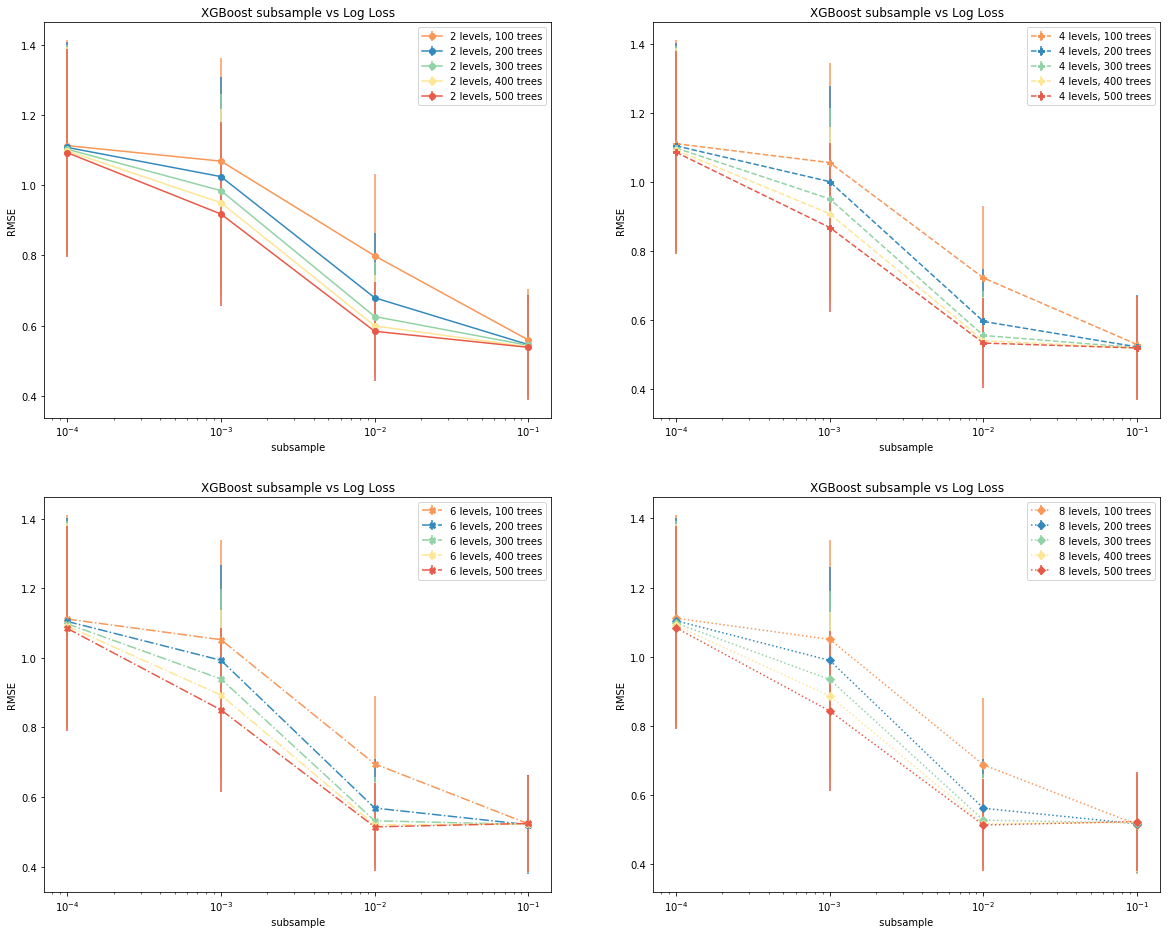

In [106]:
# plot
fig, axs = plt.subplots(2,2,figsize=[20,16])

axs = axs.flatten()

linestyle = ['-','--','-.',':']
markstyle = ['o','P','X','D', 's']
nn=0
for d in [2, 4, 6, 8]:
    mm = 0
    ax = axs[nn]
    for m in n_estimators:

        x = []
        y = []
        yerr = []

        for n in range(len(means)):
            #print(params[n]['max_depth'])
            if (params[n]['max_depth']==d) & (params[n]['n_estimators']==m):
                x.append(params[n]['eta'])
                y.append(means[n])
                yerr.append(stds[n])
        #print(y)
        ax.errorbar(x, y, yerr=yerr, marker=markstyle[nn], linestyle=linestyle[nn], color=colors[mm], label=f'{d} levels, {m} trees')
        #ax.errorbar(mdep, means, yerr=stds, marker='.', linestyle='')
        #ax.errorbar(mchw, means, yerr=stds, marker='.', linestyle='')
        #ax.errorbar(nest, means, yerr=stds, marker='.', linestyle='')
        mm+=1
        
    ax.set_title("XGBoost:Log Loss vs. eta")
    ax.set_xscale('log')
    ax.set_xlabel( ' subsample ' )
    ax.set_ylabel( 'RMSE' )
    ax.legend()
    nn+=1

#pplt.savefig( ' subsample.png ' )

Here is the config for the best working version from the code above:
```
search.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.00999999978,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
```

In [20]:
model_best = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.00999999978,
             max_delta_step=0, max_depth=8, min_child_weight=1.0,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)

#best_params = search.best_estimator_.get_xgb_params
best_params = model_best.get_xgb_params

In [22]:
#model_best = search.best_estimator_

eval_set = [(X_train, y_train), (X_test, y_test)]
model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:1.11227	validation_1-rmse:1.11153
[1]	validation_0-rmse:1.10354	validation_1-rmse:1.10370
[2]	validation_0-rmse:1.09483	validation_1-rmse:1.09587
[3]	validation_0-rmse:1.08645	validation_1-rmse:1.08817
[4]	validation_0-rmse:1.08095	validation_1-rmse:1.08310
[5]	validation_0-rmse:1.07243	validation_1-rmse:1.07542
[6]	validation_0-rmse:1.06402	validation_1-rmse:1.06805
[7]	validation_0-rmse:1.05584	validation_1-rmse:1.06062
[8]	validation_0-rmse:1.04776	validation_1-rmse:1.05348
[9]	validation_0-rmse:1.03973	validation_1-rmse:1.04644
[10]	validation_0-rmse:1.03192	validation_1-rmse:1.03952
[11]	validation_0-rmse:1.02397	validation_1-rmse:1.03278
[12]	validation_0-rmse:1.01860	validation_1-rmse:1.02818
[13]	validation_0-rmse:1.01090	validation_1-rmse:1.02124
[14]	validation_0-rmse:1.00598	validation_1-rmse:1.01687
[15]	validation_0-rmse:1.00090	validation_1-rmse:1.01244
[16]	validation_0-rmse:0.99327	validation_1-rmse:1.00607
[17]	validation_0-rmse:0.98586	validation

[144]	validation_0-rmse:0.50432	validation_1-rmse:0.62918
[145]	validation_0-rmse:0.50217	validation_1-rmse:0.62802
[146]	validation_0-rmse:0.50005	validation_1-rmse:0.62696
[147]	validation_0-rmse:0.49893	validation_1-rmse:0.62640
[148]	validation_0-rmse:0.49685	validation_1-rmse:0.62525
[149]	validation_0-rmse:0.49555	validation_1-rmse:0.62442
[150]	validation_0-rmse:0.49446	validation_1-rmse:0.62368
[151]	validation_0-rmse:0.49245	validation_1-rmse:0.62267
[152]	validation_0-rmse:0.49043	validation_1-rmse:0.62155
[153]	validation_0-rmse:0.48860	validation_1-rmse:0.62047
[154]	validation_0-rmse:0.48661	validation_1-rmse:0.61939
[155]	validation_0-rmse:0.48477	validation_1-rmse:0.61828
[156]	validation_0-rmse:0.48288	validation_1-rmse:0.61723
[157]	validation_0-rmse:0.48102	validation_1-rmse:0.61631
[158]	validation_0-rmse:0.47917	validation_1-rmse:0.61544
[159]	validation_0-rmse:0.47806	validation_1-rmse:0.61492
[160]	validation_0-rmse:0.47627	validation_1-rmse:0.61404
[161]	validati

[286]	validation_0-rmse:0.35970	validation_1-rmse:0.56796
[287]	validation_0-rmse:0.35940	validation_1-rmse:0.56790
[288]	validation_0-rmse:0.35912	validation_1-rmse:0.56781
[289]	validation_0-rmse:0.35887	validation_1-rmse:0.56772
[290]	validation_0-rmse:0.35827	validation_1-rmse:0.56751
[291]	validation_0-rmse:0.35797	validation_1-rmse:0.56742
[292]	validation_0-rmse:0.35735	validation_1-rmse:0.56734
[293]	validation_0-rmse:0.35704	validation_1-rmse:0.56724
[294]	validation_0-rmse:0.35645	validation_1-rmse:0.56712
[295]	validation_0-rmse:0.35588	validation_1-rmse:0.56699
[296]	validation_0-rmse:0.35536	validation_1-rmse:0.56696
[297]	validation_0-rmse:0.35481	validation_1-rmse:0.56690
[298]	validation_0-rmse:0.35455	validation_1-rmse:0.56683
[299]	validation_0-rmse:0.35401	validation_1-rmse:0.56662
[300]	validation_0-rmse:0.35351	validation_1-rmse:0.56643
[301]	validation_0-rmse:0.35302	validation_1-rmse:0.56629
[302]	validation_0-rmse:0.35253	validation_1-rmse:0.56626
[303]	validati

[428]	validation_0-rmse:0.31585	validation_1-rmse:0.56049
[429]	validation_0-rmse:0.31557	validation_1-rmse:0.56049
[430]	validation_0-rmse:0.31536	validation_1-rmse:0.56040
[431]	validation_0-rmse:0.31520	validation_1-rmse:0.56039
[432]	validation_0-rmse:0.31495	validation_1-rmse:0.56041
[433]	validation_0-rmse:0.31482	validation_1-rmse:0.56038
[434]	validation_0-rmse:0.31453	validation_1-rmse:0.56041
[435]	validation_0-rmse:0.31432	validation_1-rmse:0.56033
[436]	validation_0-rmse:0.31409	validation_1-rmse:0.56035
[437]	validation_0-rmse:0.31389	validation_1-rmse:0.56038
[438]	validation_0-rmse:0.31372	validation_1-rmse:0.56029
[439]	validation_0-rmse:0.31343	validation_1-rmse:0.56028
[440]	validation_0-rmse:0.31326	validation_1-rmse:0.56031
[441]	validation_0-rmse:0.31311	validation_1-rmse:0.56029
[442]	validation_0-rmse:0.31289	validation_1-rmse:0.56032
[443]	validation_0-rmse:0.31278	validation_1-rmse:0.56029
[444]	validation_0-rmse:0.31265	validation_1-rmse:0.56024
[445]	validati

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.01,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.00999999978,
             max_delta_step=0, max_depth=8, min_child_weight=1.0, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)

In [23]:
from sklearn.metrics import accuracy_score

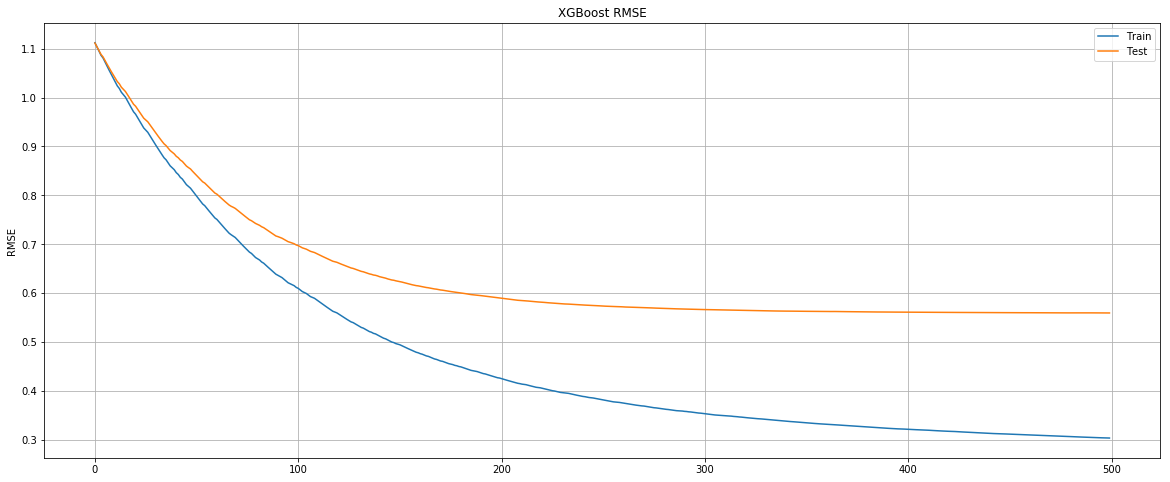

In [24]:
# make predictions for test data
predictions = model_best.predict(X_test)
# evaluate predictions
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model_best.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot RMSE
fig, ax = plt.subplots(figsize=[20,8])
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

### Hyperparam. tuning

#### Some params and heuristic settings

* Number of Trees (`nr_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
* Learning Rate (`learning_rate`) simplified to the ratio: number of trees: $[2 -10]/\#\mathrm{trees}$
* Row Sampling (`subsample`) grid searched values in the range `[0.5, 0.75, 1.0]`.
* Column Sampling (`colsample_bytree`) and maybe `colsample_bylevel`) grid searched values in the range `[0.4, 0.6, 0.8, 1.0]`.
* Min Leaf Weight (`min_child_weight`) simplified to the ratio, $3/(\#\mathrm{rare}\;\mathrm{events})$ is the percentage of rare event observations in the dataset.
* Tree Size (`max_depth`) grid searched values in the rage `[4, 6, 8, 10]`.

#### On trees and learning
* More trees (`nr_estimators`) $\to$ more corrections of residuals $\to$ overfitting
* Slower learning (`eta` or `learning_rate`, or "shrinkage") means less corrections and less overfitting

#### Notes
* once the 'test' curve asymptotes, the computation can be ended since the fitter will overfit 'train' with more iterations

#### Number of trees
##### `nr_estimators = 500`

CPU times: user 4min 2s, sys: 350 ms, total: 4min 3s
Wall time: 1min 3s
CPU times: user 4min 12s, sys: 514 ms, total: 4min 12s
Wall time: 1min 8s
CPU times: user 4min 13s, sys: 465 ms, total: 4min 13s
Wall time: 1min 8s
CPU times: user 3min 58s, sys: 388 ms, total: 3min 58s
Wall time: 1min 3s
CPU times: user 4min 11s, sys: 497 ms, total: 4min 12s
Wall time: 1min 9s
CPU times: user 4min 3s, sys: 499 ms, total: 4min 4s
Wall time: 1min 5s


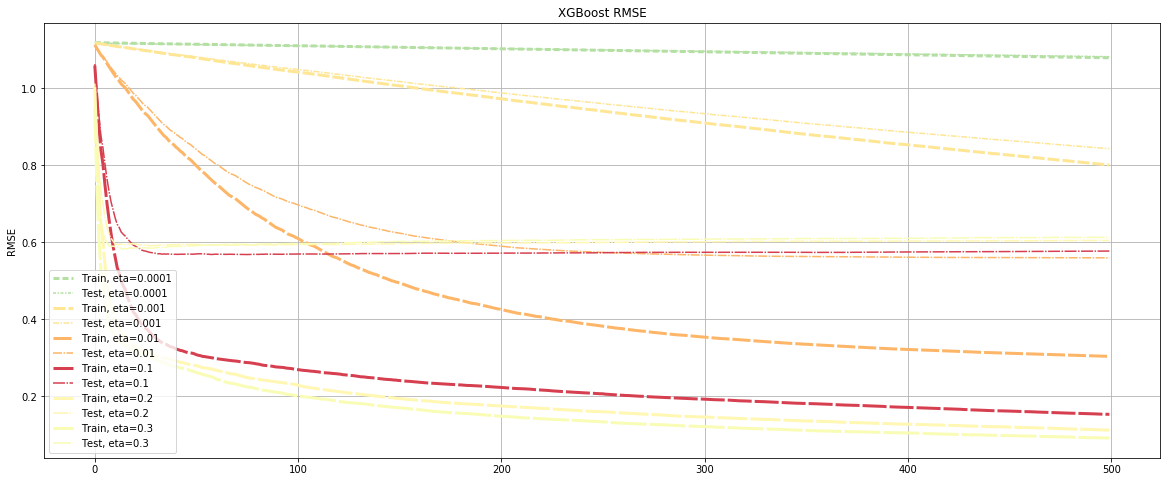

In [31]:
fig, ax = plt.subplots(figsize=[20,8])

#best_params = search.best_estimator_.get_xgb_params()
best_params = model_best.get_xgb_params()
best_params.pop('objective')

n=0
for eta in learning_rate+[0.2, 0.3]:
    
    best_params['eta'] = eta

    #model_best = search.best_estimator_ # COMMENTED: to use this after the initial GridSearch
    model_best.set_params(**{'learning_rate': eta, 'eta': eta})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model_best.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_best.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

##### `nr_estimators = 1000`

Since some of the above curves did not converge to their lowest values, try again with more estimators

<font color='red' size=3>
    NOTE: more estimators increases the tendency for overfitting
</font>

CPU times: user 8min 31s, sys: 813 ms, total: 8min 32s
Wall time: 2min 19s
CPU times: user 8min 33s, sys: 767 ms, total: 8min 34s
Wall time: 2min 18s
CPU times: user 8min 30s, sys: 813 ms, total: 8min 31s
Wall time: 2min 20s


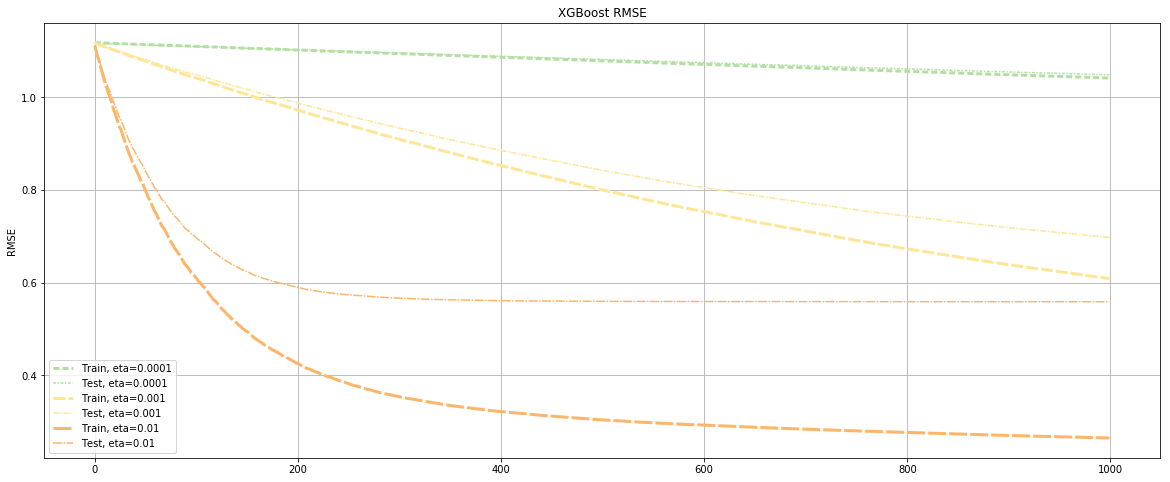

In [32]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
for eta in learning_rate[:3]:
    
    best_params['eta'] = eta

    #model_best = search.best_estimator_
    model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 1000})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model_best.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_best.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

##### `nr_estimators = 100`

For faster testing on the other parameters, use fewer estimators and then re-check with more estimators

CPU times: user 53.9 s, sys: 722 ms, total: 54.6 s
Wall time: 16.9 s
CPU times: user 1min, sys: 917 ms, total: 1min 1s
Wall time: 20.5 s
CPU times: user 54.2 s, sys: 491 ms, total: 54.7 s
Wall time: 16.4 s
CPU times: user 49.2 s, sys: 167 ms, total: 49.3 s
Wall time: 14 s
CPU times: user 47.9 s, sys: 568 ms, total: 48.5 s
Wall time: 13.7 s
CPU times: user 45.8 s, sys: 111 ms, total: 46 s
Wall time: 12.3 s


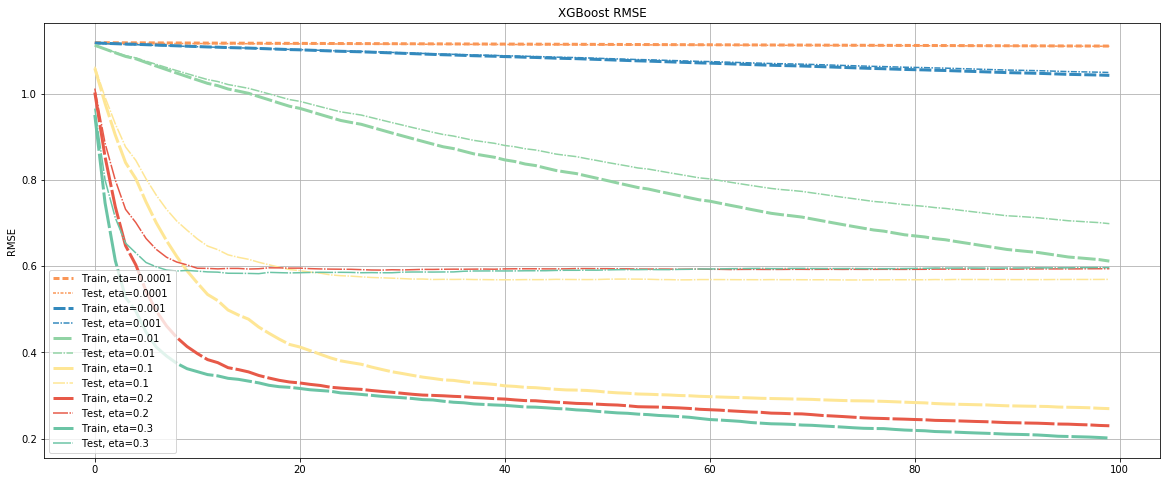

In [183]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
for eta in learning_rate+[0.2, 0.3]:
    
    best_params['eta'] = eta

    #model_best = search.best_estimator_
    model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 100})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model_best.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_best.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

#### Early stopping

CPU times: user 2min 30s, sys: 290 ms, total: 2min 30s
Wall time: 40.5 s
CPU times: user 2min 27s, sys: 223 ms, total: 2min 27s
Wall time: 38.9 s
CPU times: user 2min 24s, sys: 212 ms, total: 2min 24s
Wall time: 37.8 s
CPU times: user 59.1 s, sys: 160 ms, total: 59.3 s
Wall time: 15.5 s
CPU times: user 37.8 s, sys: 132 ms, total: 38 s
Wall time: 9.94 s
CPU times: user 32.5 s, sys: 111 ms, total: 32.6 s
Wall time: 8.58 s


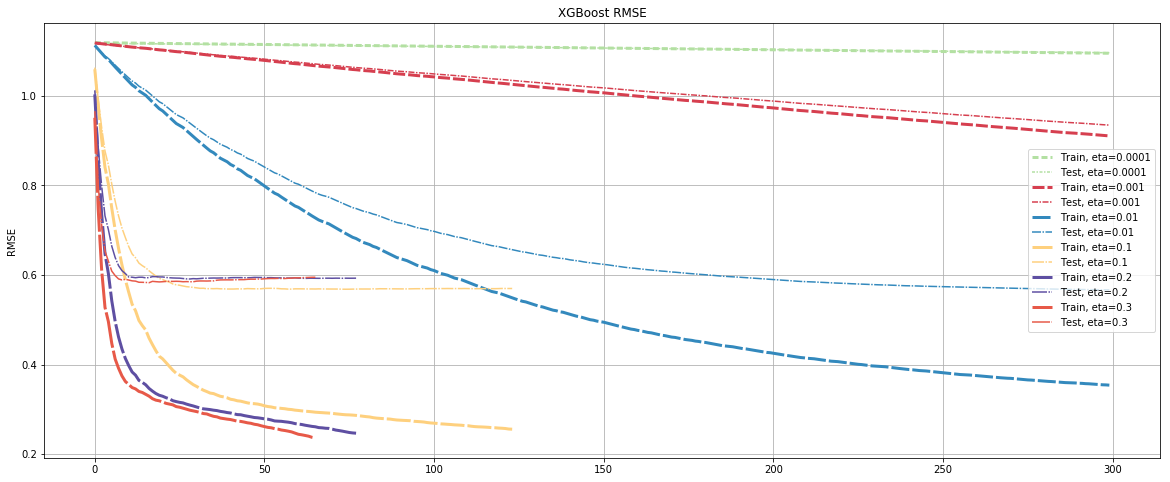

In [314]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
for eta in learning_rate+[0.2, 0.3]:

    #model_best = search.best_estimator_ # COMMENTED: to use this after the initial GridSearch
    model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'nr_estimators':500})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False,early_stopping_rounds=50)
    
    # make predictions for test data
    predictions = model_best.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_best.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

In [273]:
sys.path.append('../../../../preferences')
from my_matplotlib_styles_and_prefs import markers_dicts, dashes_dicts

In [274]:
random.shuffle(dashes_dicts)

In [275]:
random.shuffle(markers_dicts)

In [37]:
random.shuffle(colors)

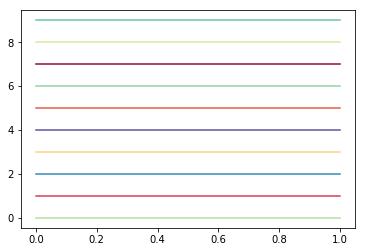

In [38]:
for n in range(10):
    plt.plot([0,1],[n,n],color=colors[n])

CPU times: user 2min 37s, sys: 391 ms, total: 2min 37s
Wall time: 44.2 s
CPU times: user 2min 29s, sys: 343 ms, total: 2min 29s
Wall time: 40.4 s
CPU times: user 2min 24s, sys: 367 ms, total: 2min 24s
Wall time: 38.2 s


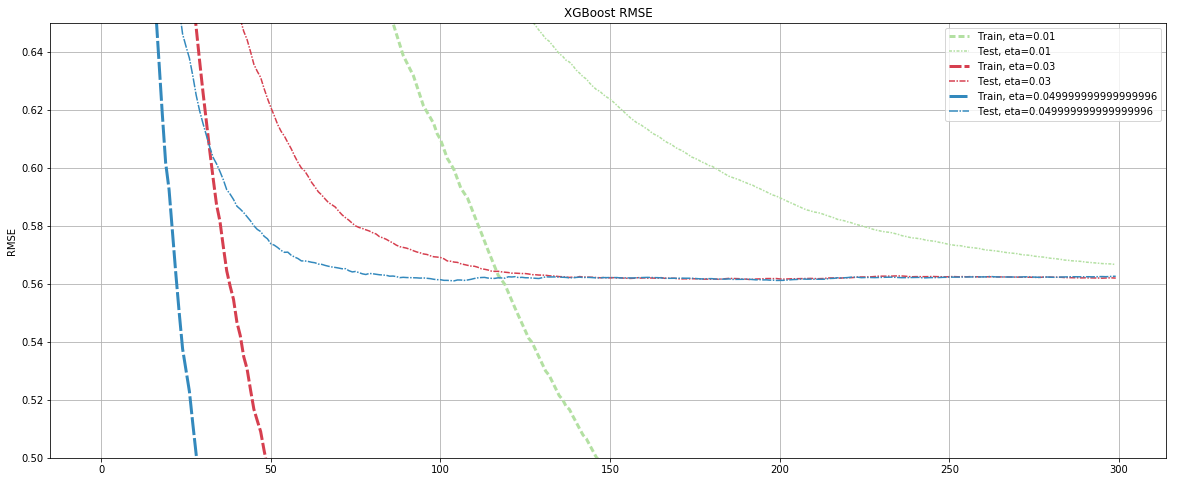

In [40]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
for eta in np.arange(0.01,0.06,0.02).tolist():

    best_params['eta'] = eta

    #model_best = search.best_estimator_
    model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 300})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model_best.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_best.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.ylim(0.50, 0.65)
plt.grid()

#### Row sampling

##### `subsample`

CPU times: user 47.8 s, sys: 136 ms, total: 47.9 s
Wall time: 13.8 s
CPU times: user 59.2 s, sys: 608 ms, total: 59.8 s
Wall time: 16.7 s
CPU times: user 1min 3s, sys: 181 ms, total: 1min 3s
Wall time: 17.7 s
CPU times: user 1min 4s, sys: 381 ms, total: 1min 4s
Wall time: 18 s


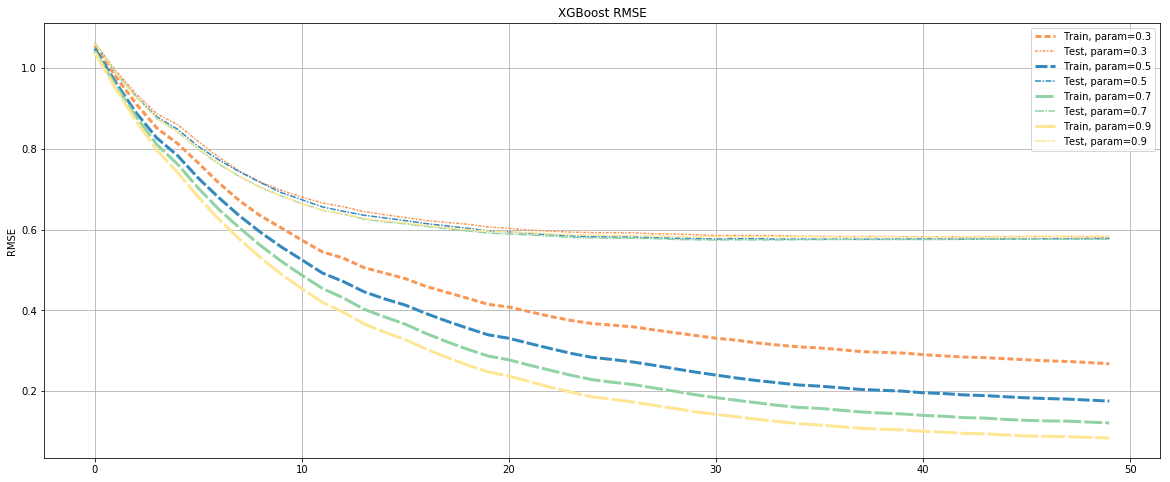

In [190]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
eta = 0.1
for val in [0.3, 0.5, 0.7, 0.9]:
    
    best_params['eta'] = eta

    #model_best = search.best_estimator_
    #model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 50, 'max_depth':8}) #Doesn't change much
    #model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 50, 'min_child_weight':0.5}) #slightly worse
    model_best.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 50, 'subsample': val})


    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_best.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model_best.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_best.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, param={val}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, param={val}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

Was:

```
eta=0.01,
learning_rate=0.01,
max_depth=8, 
min_child_weight=1.0,
```

In [42]:
model_300 = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)

params_300 = model_300.get_xgb_params()
params_300.pop('objective')

'reg:squarederror'

CPU times: user 3min 3s, sys: 283 ms, total: 3min 3s
Wall time: 47.7 s
CPU times: user 3min 3s, sys: 175 ms, total: 3min 3s
Wall time: 47.6 s
CPU times: user 3min 2s, sys: 208 ms, total: 3min 3s
Wall time: 47.5 s
CPU times: user 3min 1s, sys: 271 ms, total: 3min 1s
Wall time: 47.2 s


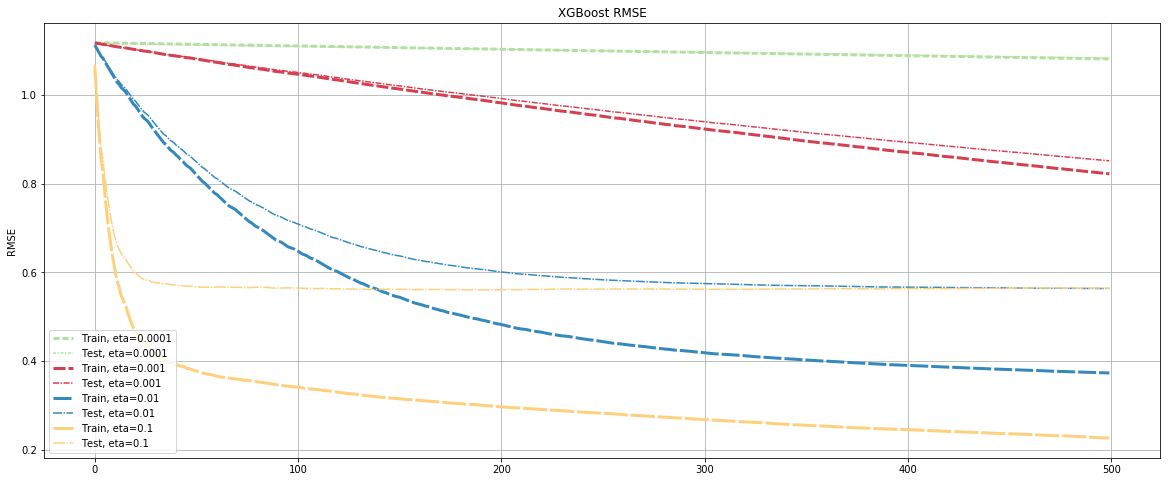

In [44]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
for eta in learning_rate:
    
    params_300['eta'] = eta

    #model_best = search.best_estimator_
    model_300.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 500})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model_300.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model_300.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model_300.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

### Overfitting?

10.06.2020: 
> Earlier results showed better scores: _however_, the problem was in using the full dataset for the evaluation.<br/>
> This means training with $\mathbf{X}$ and then testing with $\mathbf{X}_{\mathrm{test}} \subset \mathbf{X}$.
> * this is why: $\mathbf{X}_{\mathrm{test}} \cap \mathbf{X}_{\mathrm{train}} = \emptyset$
>
> (Specifically, this was done when using $\mathbf{X}_{\mathrm{train}},\mathbf{y}_{\mathrm{train}}$ for a k-fold cross validated fit in a grid search, and then _using the same_ $\mathbf{y}_{\mathrm{train}}$ for the prediction. Nice one!)

In [ ]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
     'n_estimators': 100,
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

CPU times: user 39.5 s, sys: 242 ms, total: 39.8 s
Wall time: 11.3 s
CPU times: user 37.7 s, sys: 172 ms, total: 37.8 s
Wall time: 10.4 s
CPU times: user 47.2 s, sys: 158 ms, total: 47.3 s
Wall time: 14.8 s
CPU times: user 42.8 s, sys: 182 ms, total: 43 s
Wall time: 12.7 s


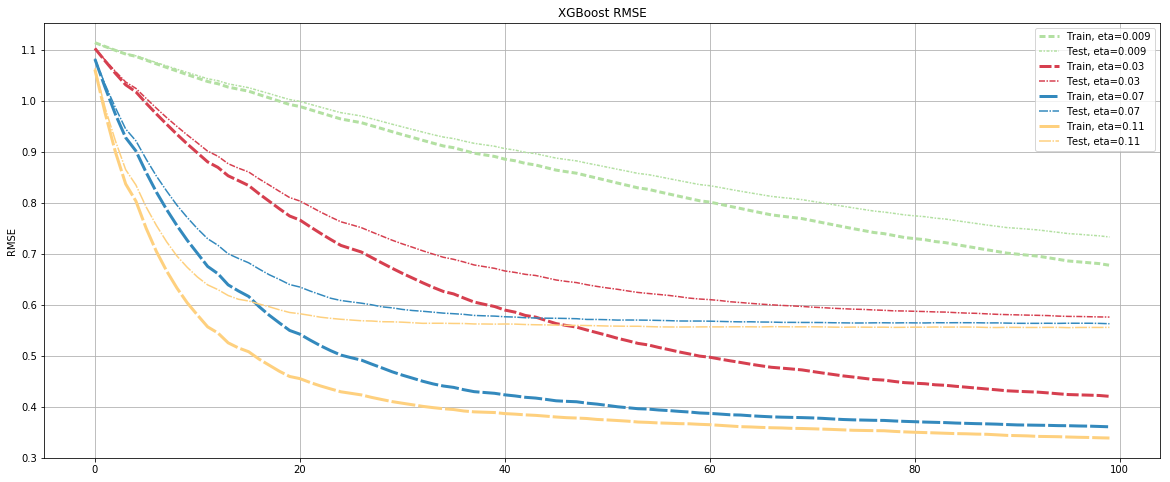

In [46]:
fig, ax = plt.subplots(figsize=[20,8])

n=0
for eta in [0.009, 0.03, 0.07, 0.11]:
    
    #model_best = search.best_estimator_
    model.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': 100})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    ax.plot(x_axis, results['validation_0']['rmse'], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results['validation_1']['rmse'], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    
    n+=1
    #if n>1:break
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

#### Overfitting 2

```
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
```

In [59]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'min_child_weight':1.1, 
    'eval_metric': 'rmse',
     'n_estimators': 300,
    'silent': 1
}

In [ ]:
model2 = xgb.XGBRegressor(**xgb_params)

In [118]:
n_estimators = 2000

results_0 = np.empty(shape=[n_estimators,0])
results_1= np.empty(shape=[n_estimators,0])
x_axis = range(0, n_estimators)

for eta in [0.009, 0.03, 0.07, 0.11]:
    
    #model_best = search.best_estimator_
    model2.set_params(**{'learning_rate': eta, 'eta': eta, 'n_estimators': n_estimators})
    eval_set = [(X_train, y_train), (X_test, y_test)]
    %time model2.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=False)
    
    # make predictions for test data
    predictions = model2.predict(X_test)
    # evaluate predictions
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model2.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    # plot RMSE

    results_0 = np.hstack([results_0,np.array(results['validation_0']['rmse']).reshape(-1,1)])
    results_1 = np.hstack([results_1,np.array(results['validation_1']['rmse']).reshape(-1,1)])
        
    n+=1

CPU times: user 11min 54s, sys: 656 ms, total: 11min 55s
Wall time: 3min 6s
CPU times: user 11min 57s, sys: 616 ms, total: 11min 57s
Wall time: 3min 6s
CPU times: user 12min 4s, sys: 608 ms, total: 12min 5s
Wall time: 3min 8s
CPU times: user 12min 3s, sys: 610 ms, total: 12min 3s
Wall time: 3min 7s


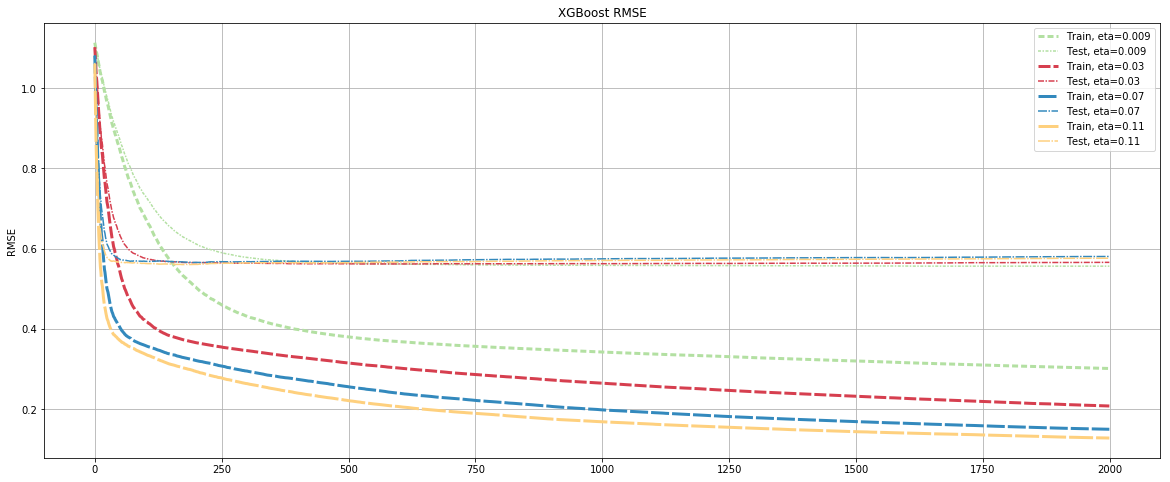

In [119]:
fig, ax = plt.subplots(figsize=[20,8])

n = 0
for eta in [0.009, 0.03, 0.07, 0.11]:

    ax.plot(x_axis, results_0[:,n], dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'Train, eta={eta}')
    ax.plot(x_axis, results_1[:,n], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    n+=1
    
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

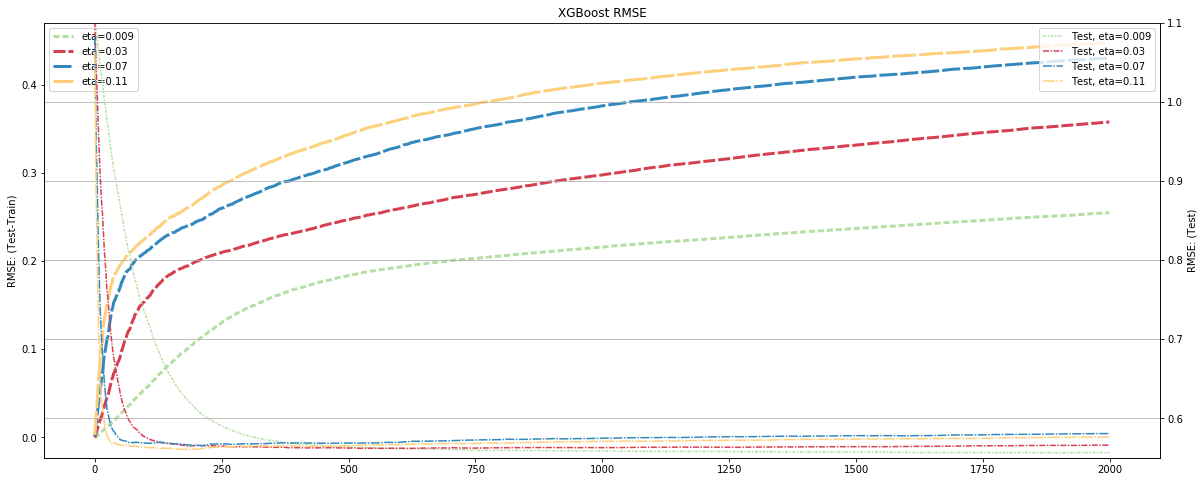

In [120]:
fig, ax = plt.subplots(figsize=[20,8])

tax = ax.twinx()
n = 0
for eta in [0.009, 0.03, 0.07, 0.11]:

    ax.plot(x_axis, (results_1[:,n]-results_0[:,n]), dashes=[2*(n+1),1], color=colors[n], lw=3, label=f'eta={eta}')
    
    tax.plot(x_axis, results_1[:,n], dashes=[2*(n+1),1,1,1], color=colors[n], label=f'Test, eta={eta}')
    n += 1


tax.set_ylim(0.55, 1.1)
    
ax.legend()
tax.legend()

ax.set_ylabel('RMSE: (Test-Train)')
tax.set_ylabel('RMSE: (Test)')

plt.title('XGBoost RMSE')
#plt.show()
plt.grid()

#### New metrics: $\Delta_{\mathrm{train,test}}$ vs Test

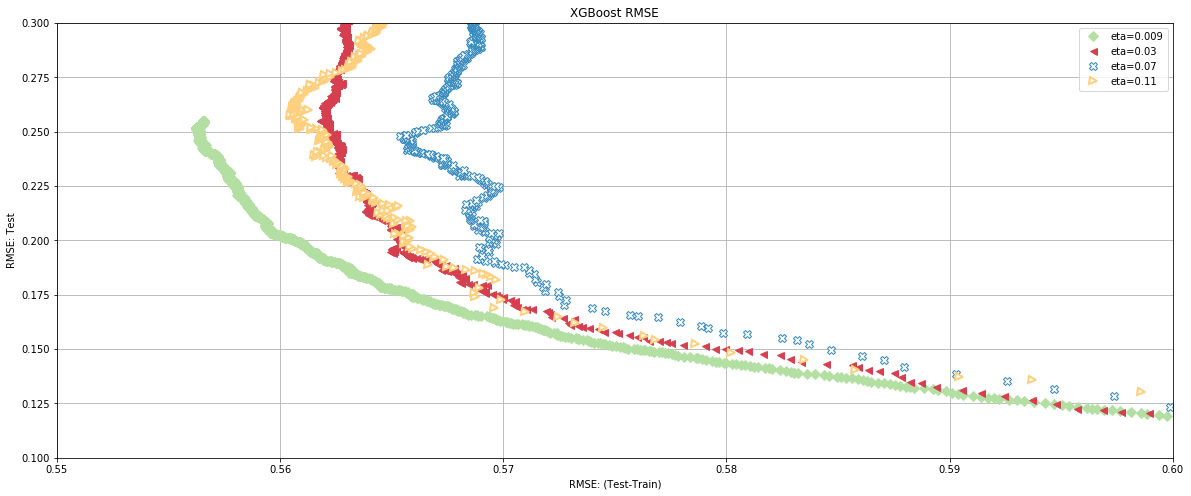

In [291]:
fig, ax = plt.subplots(figsize=[20,8])

n = 0
for eta in [0.009, 0.03, 0.07, 0.11]:

    ax.plot(results_1[:,n], (results_1[:,n]-results_0[:,n]), 
            linestyle='', **markers_dicts[n], color=colors[n], label=f'eta={eta}')
    n+=1
    
ax.legend()
plt.xlabel('RMSE: (Test-Train)')
plt.ylabel('RMSE: Test')
plt.title('XGBoost RMSE')
plt.ylim(0.10,0.3)
plt.xlim(0.55,0.6)
plt.grid()

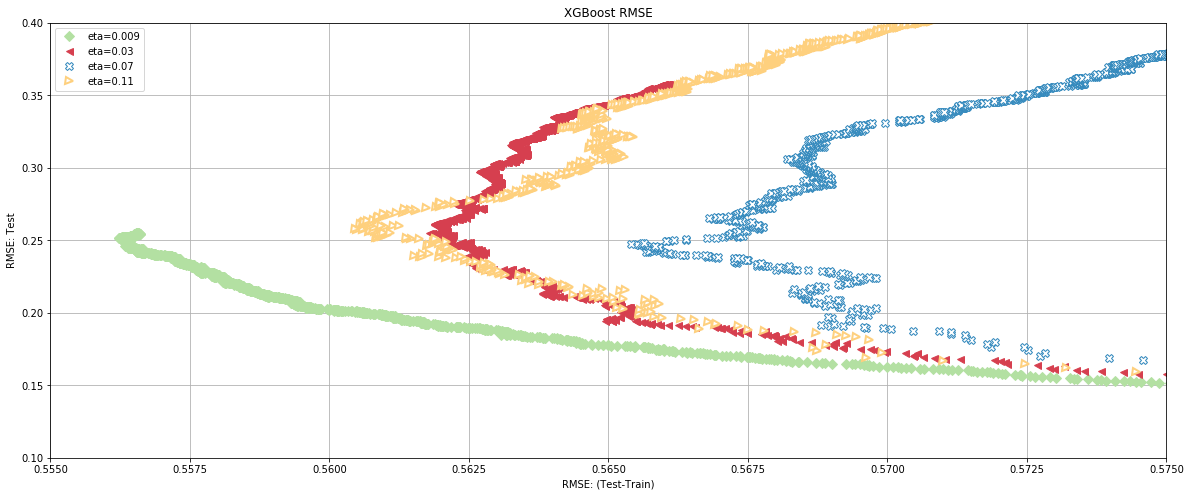

In [295]:
fig, ax = plt.subplots(figsize=[20,8])

n = 0
for eta in [0.009, 0.03, 0.07, 0.11]:

    ax.plot(results_1[:,n], (results_1[:,n]-results_0[:,n]), 
            linestyle='', color=colors[n], **markers_dicts[n], label=f'eta={eta}')
    n+=1
    
ax.legend()
plt.xlabel('RMSE: (Test-Train)')
plt.ylabel('RMSE: Test')
plt.title('XGBoost RMSE')
plt.ylim(0.10,0.4)
plt.xlim(0.555,0.575)
plt.grid()

**Note** the plots above show the optimals but don't show _when_ they occur. <br/>
Better to make a vector from $\Delta_{\mathrm{train,test}}$ and $\mathrm{test}$, and follow it's norm over the iterations


In [296]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [319]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [335]:
x_axis = range(2000)

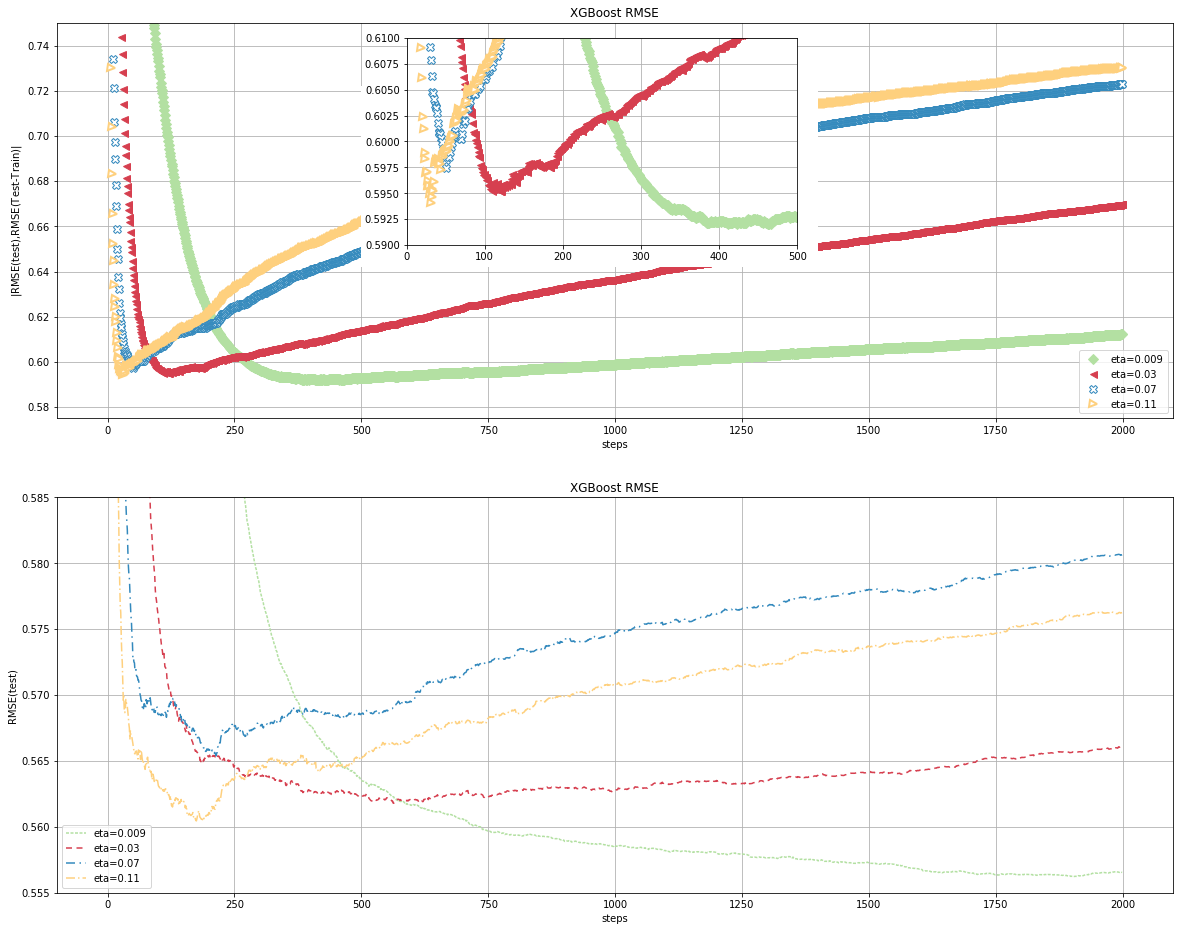

In [369]:
fig, axs = plt.subplots(2,1, figsize=[20,16])

axs = axs.flatten()
ax = axs[0]

ax1 = axs[1]

recta = Rectangle((500, .642), width=900, height=.08, zorder=1)
pc = PatchCollection([recta], \
                     facecolor='w', alpha=1, edgecolor='w',linewidth=0, zorder=100)


# Add collections to axes
ax.add_collection(pc)

axins = inset_axes(ax, width="50%", height="75%",
                   bbox_to_anchor=(.3, .4, .7, .7),
                   bbox_transform=ax.transAxes, loc=3,borderpad=1.5)


#tax = ax.twinx()

n = 0
for eta in [0.009, 0.03, 0.07, 0.11]:
    
    norms = [np.linalg.norm([results_1[m,n], (results_1[m,n]-results_0[m,n])]) for m in x_axis]
    
    ax.plot(x_axis, norms, 
            linestyle='', color=colors[n], **markers_dicts[n], label=f'eta={eta}')
    axins.plot(x_axis, norms, 
            linestyle='', color=colors[n], **markers_dicts[n], label=f'eta={eta}')    
    
    ax1.plot(x_axis, results_1[:,n], 
            linestyle='', color=colors[n], **dashes_dicts[n], label=f'eta={eta}')    
    
    n+=1
    
ax.legend()
ax.set_ylabel(r'$\|$RMSE(test)-RMSE(Test-Train)$\|$')
ax.set_xlabel('steps')
ax.set_title('XGBoost RMSE')
ax.set_ylim(0.575,0.750)
#plt.xlim(0.555,0.575)
ax.grid()

ax1.legend()
ax1.set_ylabel('RMSE(test)')
ax1.set_xlabel('steps')
ax1.set_title('XGBoost RMSE')
ax1.set_ylim(0.555,0.585)
#plt.xlim(0.555,0.575)
ax1.grid()

axins.set_xlim(0,500)
axins.set_ylim(0.59,0.61)

axins.grid()

<hr style="border: 4px dashed #000000; border-style: none none dashed; color: #fff; background-color: #fff; height: 4.0px;"/>

## Evaluation

### Test of the larger param. set $\to$ has a larger error

In [14]:
xgb_params1 = {'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': 6,
 'min_child_weight': 1.1,
 'monotone_constraints': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'eta': 0.07,
 'eval_metric': 'rmse',
 'silent': 1}

In [35]:
model = xgb.XGBRegressor(**xgb_params1)
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [36]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print("TTS RMSE: %f" % (rmse))

TTS RMSE: 0.567856


In [37]:
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), predictions.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions+offset))
print("RMSLE: %f" % (rmsle))

RMSLE: 0.171353


In [38]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [39]:
model2 = xgb.XGBRegressor(**xgb_params1)
%time cvscorer = cross_validate(model2, X_train, y_train, cv=kfold, scoring=metric, return_estimator=True)

CPU times: user 7min 3s, sys: 1.27 s, total: 7min 4s
Wall time: 2min 7s


In [40]:
print(f"CV. RMSE: {np.sqrt(-cvscorer['test_score']).mean():.4f}")

CV. RMSE: 0.5141


In [41]:
for estimator in cvscorer['estimator']:

    # For each estimator, predict on the test set
    predictiones = estimator.predict(X_test)

    # Get the error
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predictiones))
    print("TTS RMSE: %f" % (rmse))
    
    # Need an offset since 
    #   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
    offset = abs(min(y_test.price_doc_.min(), predictiones.min()))
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictiones+offset))
    print("RMSLE: %f" % (rmsle))
    print()

TTS RMSE: 0.577484
RMSLE: 0.172660

TTS RMSE: 0.563079
RMSLE: 0.172060

TTS RMSE: 0.558467
RMSLE: 0.171741

TTS RMSE: 0.562920
RMSLE: 0.172922

TTS RMSE: 0.559836
RMSLE: 0.172532



## Experimental
<hr style="border: 4px dashed red; border-style: none none dashed; color: #fffff; background-color: white; height: 4.0px;"/>
<font color='red' size=5>
    EXPERIMENTAL 
</font>

### SOme following results
```
N-5: 0.562690
N-4: 0.563692
N-3: 0.570456
N-2: 0.564036
N-1: 0.572055
N-0: 0.569622
```

**Experiment #1**: trying with the defaults and the minimal set
<br/>
_Result_: RMSE = 0.562690

```
xgb_params_ex = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params_ex)
model_ex.fit(X_train,y_train)
predictions_ex = model_ex.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))
# Need an offset since 
#   Mean Squared Logarithmic Error cannot be used when targets contain negative values.
offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
print(offset)
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))


RMSE: 0.562690
1.4972654076461007
RMSLE: 0.172130
```

### N-4: 0.563692

In [50]:
xgb_params = {
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    
    
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)

param_grid = {
    "max_depth" : [5, 6, 7],
    "eta" : [0.07, 0.09, 0.11],
    }


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  5.3min remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.6min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.09,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0900000036,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.09, 'max_depth': 7}
0.5131
RMSE: 0.563692
RMSLE: 0.171702


### N-3: 0.570456

In [52]:
xgb_params = {
    'subsample': 0.7,
    "max_depth" : 7,
    "eta" : 0.09,    
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [100, 300, 500],
    "min_child_weight" : [1.1, 1.2, 1.3],
    }


search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 17.4min remaining:   48.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 18.3min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.09,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0900000036,
             max_delta_step=0, max_depth=7, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'min_child_weight': 1.1, 'n_estimators': 100}
0.5168
RMSE: 0.570456
RMSLE: 0.172172


### N-2: 0.564036

In [53]:
xgb_params = {
    'subsample': 0.7,
    "max_depth" : 7,
    "eta" : 0.09,    
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [100, 200, 300],    
    'colsample_bytree':[0.5, 0.7, 0.9],
    'subsample':[0.5, 0.7, 0.9]
    }

search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 35.7min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.09,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0900000036,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'colsample_bytree': 0.7, 'n_estimators': 200, 'subsample': 0.7}
0.5126
RMSE: 0.564036
RMSLE: 0.171445


In [55]:
search.cv_results_

{'mean_fit_time': array([ 23.30845981,  23.61544251,  22.88489766,  46.94186916,
         47.617837  ,  46.56034598,  73.78017197,  73.13778114,
         70.26384382,  32.53985987,  32.25677891,  32.48364744,
         65.89543567,  64.93950381,  63.40083737,  99.94564009,
         94.37032404,  89.79773583,  39.23115401,  39.83915401,
         38.60517254,  77.43091445,  78.98407464,  75.89350829,
        116.80952826, 118.0256762 ,  95.77917452]),
 'std_fit_time': array([ 0.43962384,  0.27912037,  0.22010104,  0.57786576,  0.55034315,
         0.23304726,  1.06589307,  0.93768927,  0.42196566,  0.38343033,
         0.28245174,  1.19755869,  0.63838717,  0.69170381,  0.53608061,
         1.31795093,  1.17764699,  1.15359172,  0.55062784,  0.69981463,
         0.36856057,  0.91738938,  0.98335481,  0.74189199,  1.1937134 ,
         0.76751477, 16.13844588]),
 'mean_score_time': array([0.08800654, 0.08775697, 0.08467011, 0.14535961, 0.15573416,
        0.14275455, 0.20467939, 0.20729847,

In [57]:
xgb_params = {
    'gamma': 0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [100, 200, 300],    
    "max_depth" : [6, 7],
    "min_child_weight" : [1.1, 1.2, 1.3],    
    "eta" : [0.07, 0.09],
    }

search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 42

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=7, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.07, 'max_depth': 7, 'min_child_weight': 1.1, 'n_estimators': 200}
0.5111
RMSE: 0.572055
RMSLE: 0.171650


In [58]:
xgb_params = {
    'gamma': 0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model_ex = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [100, 200, 300],    
    "max_depth" : [6, 7, 8],
    "min_child_weight" : [1.0, 1.1, 1.2],    
    "eta" : [0.06, 0.07, 0.08],
    }

search = GridSearchCV(model_ex, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X_train, y_train, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

predictions_ex = search.best_estimator_.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions_ex))
print("RMSE: %f" % (rmse))

offset = abs(min(y_test.price_doc_.min(), predictions_ex.min()))
rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+offset, predictions_ex+offset))
print("RMSLE: %f" % (rmsle))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 42

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.08,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0799999982,
             max_delta_step=0, max_depth=7, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.08, 'max_depth': 7, 'min_child_weight': 1.1, 'n_estimators': 200}
0.5096
RMSE: 0.569622
RMSLE: 0.171612


Best: -0.259704 using {'eta': 0.08, 'max_depth': 7, 'min_child_weight': 1.1, 'n_estimators': 200}
-0.267324 (0.020972) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 100}
-0.263128 (0.020032) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 200}
-0.261545 (0.020150) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 300}
-0.269886 (0.019871) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.1, 'n_estimators': 100}
-0.266333 (0.020062) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.1, 'n_estimators': 200}
-0.264105 (0.019153) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.1, 'n_estimators': 300}
-0.269886 (0.019871) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.2, 'n_estimators': 100}
-0.266333 (0.020062) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1.2, 'n_estimators': 200}
-0.264105 (0.019153) with: {'eta': 0.06, 'max_depth': 6, 'min_child_weight': 1

Text(0, 0.5, ' Log Loss ')

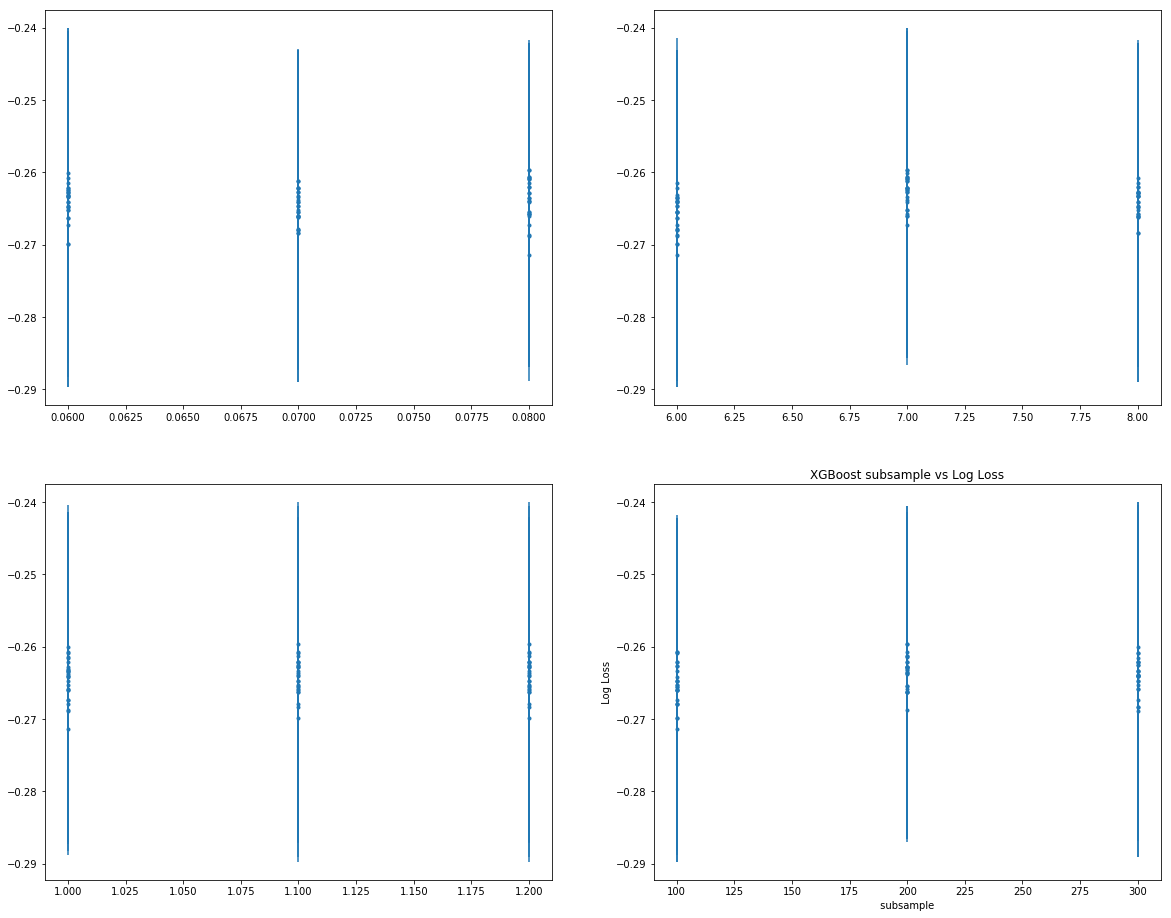

In [72]:
'''subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
'''
eta = [0.06, 0.07, 0.08]
# summarize results
print("Best: %f using %s" % (search.best_score_, search.best_params_))
means = search.cv_results_[ 'mean_test_score' ]
stds = search.cv_results_[ 'std_test_score' ]
params = search.cv_results_[ 'params' ]
etas = []
mdep = []
mchw = []
nest = []
for mean, stdev, param in zip(means, stds, params):    
    print("%f (%f) with: %r" % (mean, stdev, param))
    etas.append(param['eta'])
    mdep.append(param['max_depth'])
    mchw.append(param['min_child_weight'])
    nest.append(param['n_estimators'])
    
# plot
fig, ax = plt.subplots(2,2,figsize=[20,16])
ax[0,0].errorbar(etas, means, yerr=stds, marker='.', linestyle='')
ax[0,1].errorbar(mdep, means, yerr=stds, marker='.', linestyle='')
ax[1,0].errorbar(mchw, means, yerr=stds, marker='.', linestyle='')
ax[1,1].errorbar(nest, means, yerr=stds, marker='.', linestyle='')
plt.title("XGBoost subsample vs Log Loss")
plt.xlabel( ' subsample ' )
plt.ylabel( ' Log Loss ' )
#pplt.savefig( ' subsample.png ' )

<font color='red' size=5>
    Done EXPERIMENTAL 
</font>
<hr style="border: 4px dashed red; border-style: none none dashed; color: #fffff; background-color: white; height: 4.0px;"/>

## Track record


**Note** unless specified, all measurements are done with TTSplit

Before 14.05.2020
```
RMSLE: 0.218097
```

14.05.2020
```
RMSLE: 0.217262
```

19.05.2020, dropped the 'sub_area' feature
```
RMSLE: 0.218165
```

19.05.2020, dropped rows with distribution spikes
```
RMSLE: 0.154526
```

20.05.2020, dropped more rows with distribution spikes; updated version
```
RMSLE: 0.173733
```

20.05.2020, final version with the cleaned distribution spikes
```
RMSLE: 0.163458
```

~~28.05.2020, after GridSearch, _but_ using KFold-CV~~ The train/test data weren't split!
```
~~RMSLE: 0.141490~~
```

28.05.2020, after GridSearch using again TTSplit
```
RMSLE: 0.173176
```

```
TTS RMSE: 0.577484
RMSLE: 0.172660

TTS RMSE: 0.563079
RMSLE: 0.172060

TTS RMSE: 0.558467
RMSLE: 0.171741

TTS RMSE: 0.562920
RMSLE: 0.172922

TTS RMSE: 0.559836
RMSLE: 0.172532
```

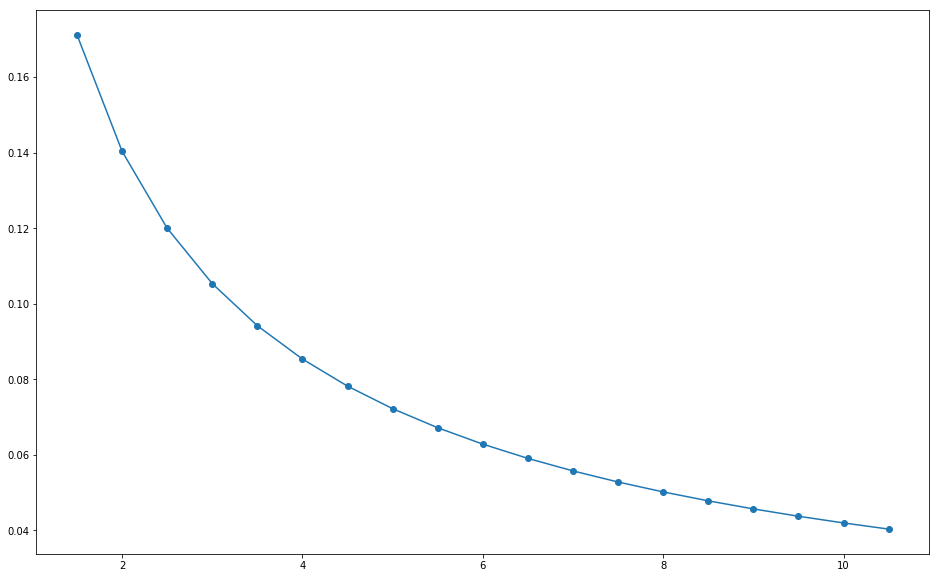

In [42]:
offsets = np.arange(1.5,11.0, 0.5)
errors = []
for x in offsets:
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_test+x, predictions+x))
    errors.append(rmsle)
errors = np.array(errors)

plt.figure(figsize=[16,10])
plt.plot(offsets, errors, 'o-')

### Distributions

In [43]:
bin_width = 0.1
bins=np.arange(-2,12 + bin_width, bin_width)
hist_train, _ = np.histogram(y_train, bins=bins)
hist_test, _ = np.histogram(y_test, bins=bins)
#hist_pred, _ = np.histogram(predictions, bins=bins)
hist_pred, _ = np.histogram(predictions, bins=bins)

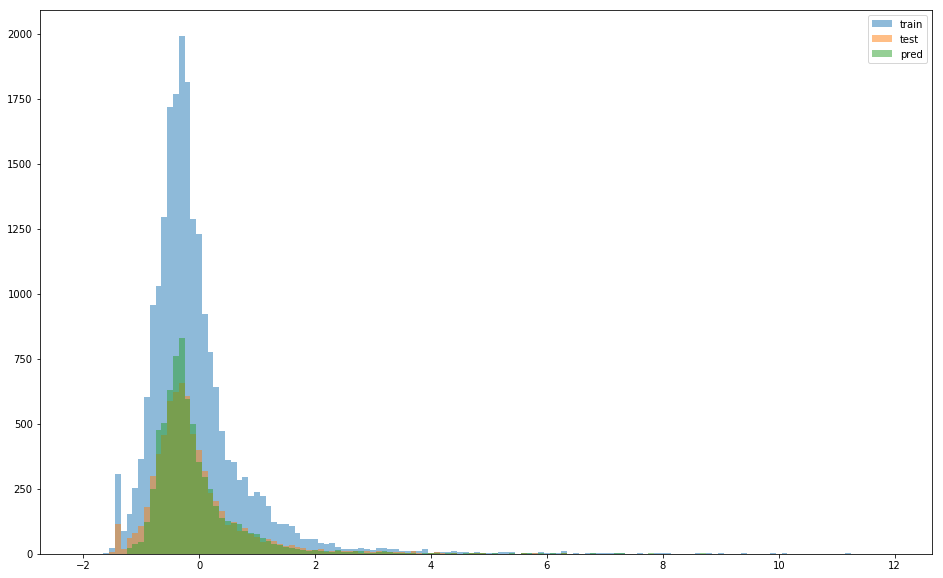

In [44]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

In [45]:
hist_train, _ = np.histogram(y_train, bins=bins, density=True)
hist_test, _ = np.histogram(y_test, bins=bins, density=True)
hist_pred, _ = np.histogram(predictions, bins=bins, density=True)

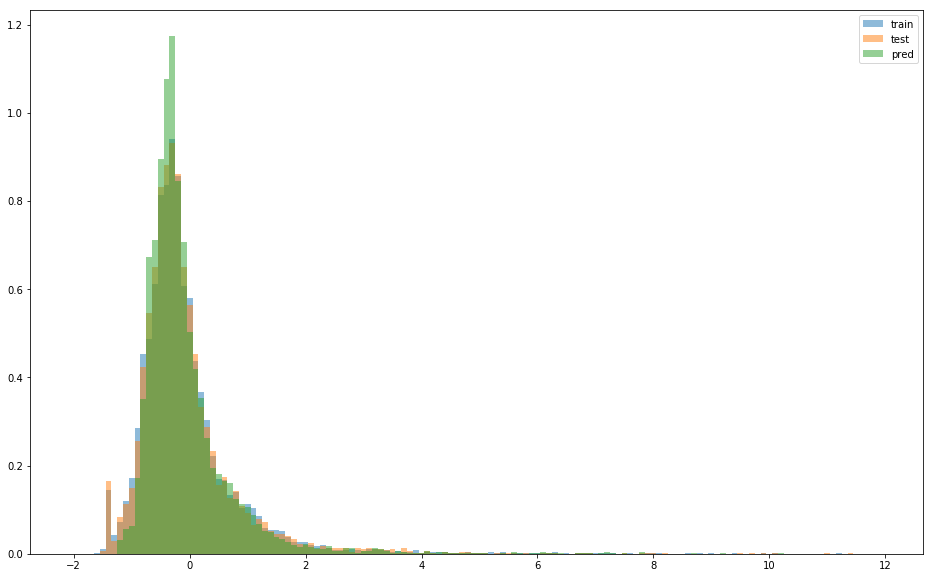

In [46]:
fig, ax = plt.subplots(1,1,figsize=[16,10])

ax.bar( x=bins[:-1],height=hist_train, width=bin_width, label='train', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_test, width=bin_width, label='test', alpha=0.5)
ax.bar( x=bins[:-1],height=hist_pred, width=bin_width, label='pred', alpha=0.5)
ax.legend();

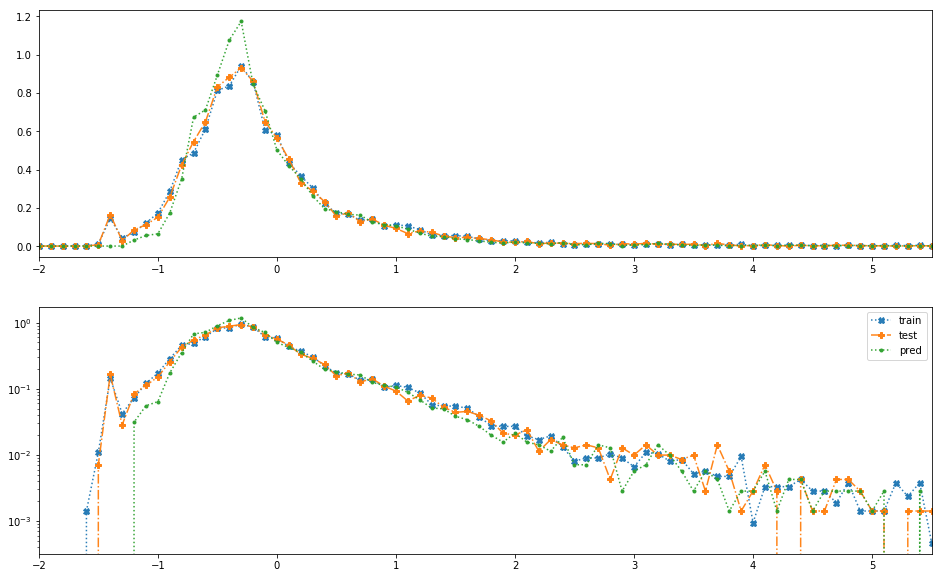

In [47]:
fig, ax = plt.subplots(2,1,figsize=[16,10])

ax =ax.reshape(2)

ax[0].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[0].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[0].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[0].set_xlim(-2.0,5.5)

ax[1].plot( bins[:-1], hist_train, 'X:', label='train', alpha=0.95)
ax[1].plot( bins[:-1], hist_test,  'P-.', label='test',  alpha=0.95)
ax[1].plot( bins[:-1], hist_pred,  '.:', label='pred',  alpha=0.95)
ax[1].set_yscale('log')
ax[1].set_xlim(-2.0,5.5)
ax[1].legend();


<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>
<font color='red' size=5>
    STOP 
</font>

## The following Grid-search results (c.f. with above!)

```
N-6: 0.5883
N-5: 0.6232
N-4: 0.5278
N-3: 0.5288
N-2: 0.5198
N-1: 0.5194
N-0: 0.5194
```


### N-6: 0.5883

In [104]:
model = xgb.XGBRegressor(objective="reg:squarederror",
                             colsample_bytree=0.46, gamma=0.047, 
                             learning_rate=0.04, max_depth=2, 
                             min_child_weight=0.5, n_estimators=2000,
                             reg_alpha=0.46, reg_lambda=0.86,
                             subsample=0.52, random_state=1, n_jobs=-1,silent=0)

param_grid = {
    'xgbregressor__max_depth' : [4, 8, 12, 16],
    'xgbregressor__estimators' : [400 ,800, 1600],
    "xgbregressor__learning_rate" : [0.02, 0.03, 0.04],
    "xgbregressor__min_child_weight" : [0.2, 0.3, 0.4, 0.5]
    }

search = GridSearchCV(model, param_grid, cv=3, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 73.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 81.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 94.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 105.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 1

{'xgbregressor__estimators': 400, 'xgbregressor__learning_rate': 0.02, 'xgbregressor__max_depth': 4, 'xgbregressor__min_child_weight': 0.2}
0.5883


### N-5: 0.6232

In [111]:
#GridSearchCV XGBoost
"""
    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: --> documentation
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf
        node of the tree.
    min_child_weight : int
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : int
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each level.
    colsample_bynode : float
        Subsample ratio of columns for each split.
    reg_alpha : float (xgb's alpha)
        L1 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L2 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
"""


xgbreg = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None,
             max_delta_step=0, max_depth=10, min_child_weight=1,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=0,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=3)

param_grid = {
    'xgbregressor__max_depth' : [8, 12],
    'xgbregressor__estimators' : [100, 200],
    "xgbregressor__learning_rate" : [0.04, 0.06],
    "xgbregressor__min_child_weight" : [0.4, 1.2],
    }

search = GridSearchCV(xgbreg, param_grid, cv=3, scoring=metric, n_jobs=-1, verbose=20)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

[09:00:58] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[09:00:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[09:00:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[09:01:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[09:01:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[09:01:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[09:01:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=10
[09:01:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[09:01:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning en

[09:01:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[09:01:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[09:01:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=10
[09:01:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[09:01:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[09:01:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[09:01:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[09:01:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[09:01:33] INFO: /worksp

In [115]:
"""
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.7, eta=0.05,
             eval_metric='rmse', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, silent=0, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)
"""


xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'xgbregressor__max_depth' : [8, 10, 12],
    "xgbregressor__learning_rate" : [0.04, 0.05, 0.06],
    }



kfold = KFold(n_splits=5, shuffle=True, random_state=1)
search = GridSearchCV(xgbreg, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=1)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

[09:28:27] ======== Monitor: Learner ========
[09:28:27] Configure: 0.001298s, 1 calls @ 1298us

[09:28:27] GetGradient: 0.136064s, 100 calls @ 136064us

[09:28:27] PredictRaw: 0.020187s, 100 calls @ 20187us

[09:28:27] UpdateOneIter: 44.8924s, 100 calls @ 44892383us

[09:28:27] ======== Monitor: GBTree ========
[09:28:27] BoostNewTrees: 42.6725s, 100 calls @ 42672518us

[09:28:27] CommitModel: 2.05905s, 100 calls @ 2059054us

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 12.8min finished


[09:41:17] DEBUG: /workspace/src/gbm/gbtree.cc:146: Using tree method: 2
[09:41:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[09:41:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[09:41:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 988 extra nodes, 0 pruned nodes, max_depth=10
[09:41:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[09:41:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=10
[09:41:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=10
[09:41:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=10
[09:41:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning en

[09:41:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[09:41:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[09:41:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=10
[09:41:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[09:41:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[09:41:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] INFO: /worksp

### N-4: 0.5278


In [124]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train,y_train)
#predictions = model.predict(X_test)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric)

In [122]:
param_grid = {
    'xgbregressor__max_depth' : [8, 10, 12],
    "xgbregressor__eta" : [0.04, 0.05, 0.06],
    }


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=0)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

{'xgbregressor__eta': 0.04, 'xgbregressor__max_depth': 8}
0.5278


In [134]:
for mdep in [6, 10, 14]:
    for eta in [0.03, 0.05, 0.07]:
        
        xgb_params = {
            'eta': eta,
            'max_depth': mdep,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            #'objective': 'reg:linear',
            # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
            'eval_metric': 'rmse',
            'silent': 1
        }

        model = xgb.XGBRegressor(**xgb_params)
        #model.fit(X_train,y_train)
        #predictions = model.predict(X_test)

        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        
        print(f"{mdep} and {eta} : {np.sqrt(-cvscorer)}")

6 and 0.03 : [0.56235599 0.55436795 0.54351341 0.55013458 0.49835918]
6 and 0.05 : [0.56025795 0.53895065 0.52990379 0.52790068 0.48509939]
6 and 0.07 : [0.5571593  0.53638571 0.51757359 0.52506484 0.48935352]
10 and 0.03 : [0.56045551 0.5589107  0.53130591 0.53865928 0.48276499]
10 and 0.05 : [0.55996603 0.5417227  0.51663691 0.52770425 0.49028224]
10 and 0.07 : [0.55871529 0.5388298  0.52046872 0.53124797 0.49394451]
14 and 0.03 : [0.56158605 0.56168899 0.53197282 0.5456208  0.4915766 ]
14 and 0.05 : [0.56352035 0.5566814  0.53096254 0.52834747 0.49521299]
14 and 0.07 : [0.56345494 0.55712817 0.52977254 0.53255232 0.49234366]


In [180]:
arr = np.array([])
n = 0
for mdep in [5, 6, 7]:
    for eta in [0.07, 0.09, 0.11]:
        
        xgb_params = {
            'eta': eta,
            'max_depth': mdep,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            #'objective': 'reg:linear',
            # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
            'eval_metric': 'rmse',
            'silent': 1
        }

        model = xgb.XGBRegressor(**xgb_params)
        #model.fit(X_train,y_train)
        #predictions = model.predict(X_test)

        if n == 0:
            arr = np.sqrt(-cvscorer)
        else:
            arr = np.vstack([arr,np.sqrt(-cvscorer)])
        
        kfold = KFold(n_splits=5, shuffle=True, random_state=1)
        %time cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        
        print(f"{mdep} and {eta} : {np.sqrt(-cvscorer)}, mean = {np.sqrt(-cvscorer).mean()}")
        n+=1

CPU times: user 1min 32s, sys: 828 ms, total: 1min 33s
Wall time: 1min 33s
5 and 0.07 : [0.56077457 0.54279565 0.52164662 0.52769164 0.49337784], mean = 0.5292572627936253
CPU times: user 1min 31s, sys: 308 ms, total: 1min 31s
Wall time: 1min 31s
5 and 0.09 : [0.55977847 0.53876098 0.5257959  0.52049635 0.49507466], mean = 0.5279812717764996
CPU times: user 1min 31s, sys: 300 ms, total: 1min 31s
Wall time: 1min 31s
5 and 0.11 : [0.55819602 0.53601322 0.52710451 0.52647031 0.50345507], mean = 0.5302478258318272
CPU times: user 1min 50s, sys: 376 ms, total: 1min 50s
Wall time: 1min 50s
6 and 0.07 : [0.5571593  0.53638571 0.51757359 0.52506484 0.48935352], mean = 0.5251073912803484
CPU times: user 1min 49s, sys: 208 ms, total: 1min 49s
Wall time: 1min 49s
6 and 0.09 : [0.56368708 0.53838457 0.51736249 0.52136593 0.49657825], mean = 0.5274756642040774
CPU times: user 1min 49s, sys: 180 ms, total: 1min 49s
Wall time: 1min 49s
6 and 0.11 : [0.56305759 0.54143402 0.51949723 0.52445857 0.49756

In [197]:
xgb_params = {
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    "max_depth" : [5, 6, 7],
    "eta" : [0.07, 0.09, 0.11],
    }


kfold = KFold(n_splits=5, shuffle=True, random_state=1)
#cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=10)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:  7.4min remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  7.7min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.07, 'max_depth': 6}
0.5256


In [215]:
# This is experiment #2 above --- repeated!
xgb_params = {
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    "max_depth" : [5, 6, 7],
    "eta" : [0.07, 0.09, 0.11],
    }


kfold = KFold(n_splits=3, shuffle=True, random_state=1)
#cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=10)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  3.6min remaining:   37.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.09,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0900000036,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'eta': 0.09, 'max_depth': 7}
0.5288


In [216]:
"""
    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: --> documentation
    gamma : float
        Minimum loss reduction required to make a further partition on a leaf
        node of the tree.
    min_child_weight : int
        Minimum sum of instance weight(hessian) needed in a child.
    max_delta_step : int
        Maximum delta step we allow each tree's weight estimation to be.
    subsample : float
        Subsample ratio of the training instance.
    colsample_bytree : float
        Subsample ratio of columns when constructing each tree.
    colsample_bylevel : float
        Subsample ratio of columns for each level.
    colsample_bynode : float
        Subsample ratio of columns for each split.
    reg_alpha : float (xgb's alpha)
        L1 regularization term on weights
    reg_lambda : float (xgb's lambda)
        L2 regularization term on weights
    scale_pos_weight : float
        Balancing of positive and negative weights.
"""

xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'gamma': [ 0, 0.05],
    #'colsample_bytree' : [0.5, 0.7],
    'n_estimators' : [100, 200],
    "min_child_weight" : [0.4, 0.8, 1.2],
    }

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
#cvscorer = cross_val_score(model, X, y, cv=kfold, scoring=metric, verbose=10)
search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.3min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.2, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0, 'min_child_weight': 1.2, 'n_estimators': 200}
0.5201


In [217]:
search.cv_results_

{'mean_fit_time': array([42.5209558 , 81.46661668, 41.26491756, 81.95709095, 42.12452459,
        85.36955175, 45.8060183 , 88.68928571, 44.23607478, 81.87720037,
        43.4821445 , 77.28267612]),
 'std_fit_time': array([ 0.95192046,  1.07209948,  1.00026047,  1.26097011,  1.30195554,
         0.97427888,  0.83708302,  1.80287587,  1.51610339,  0.80857827,
         1.61052412, 15.14742102]),
 'mean_score_time': array([0.1226717 , 0.17317767, 0.12005572, 0.1712007 , 0.10528727,
        0.24469886, 0.155863  , 0.19407988, 0.1424509 , 0.18986382,
        0.12696743, 0.15882673]),
 'std_score_time': array([0.02111155, 0.01470896, 0.01209834, 0.00889889, 0.00723817,
        0.09519782, 0.04106655, 0.05111934, 0.04997936, 0.02713014,
        0.02463149, 0.03513067]),
 'param_gamma': masked_array(data=[0, 0, 0, 0, 0, 0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fil

In [219]:
model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [100, 200, 400],
    "min_child_weight" : [1.2, 1.6, 2.0],
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 18.1min remaining:   50.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 19.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.2, missing=nan,
             monotone_constraints=None, n_estimators=400, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'min_child_weight': 1.2, 'n_estimators': 400}
0.5198


In [ ]:
search.cv_results_

In [222]:
model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'n_estimators' : [300, 500, 400],
    "min_child_weight" : [1.1, 1.2, 1.3],
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 38.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 40.5min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'min_child_weight': 1.1, 'n_estimators': 300}
0.5194


In [224]:
xgb_params = {
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_estimators' : 300,
    "min_child_weight" : 1.1,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'gamma': [ 0, 0.02, 0.05]
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.5min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'gamma': 0}
0.5194


In [225]:
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=6,
             min_child_weight=1.1, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, silent=1, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

In [226]:
xgb_params = {
    'gamma': 0,
    'eta': 0.07,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_estimators' : 300,
    "min_child_weight" : 1.1,
    #'objective': 'reg:linear',
    # 'objective':'reg:squarederror', 'n_jobs':-1, #for the feature importance
    'eval_metric': 'rmse',
    'silent': 1
}

model = xgb.XGBRegressor(**xgb_params)

param_grid = {
    'colsample_bytree':[0.3, 0.5, 0.7, 0.9],
    'subsample':[0.3, 0.5, 0.7, 0.9]
    }

search = GridSearchCV(model, param_grid, cv=kfold, scoring=metric, n_jobs=-1, verbose=10)
search.fit(X, y, verbose=False)

print(search.best_estimator_)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 29.0min finished


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.07,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.0700000003,
             max_delta_step=0, max_depth=6, min_child_weight=1.1, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=1,
             subsample=0.7, tree_method=None, validate_parameters=False,
             verbosity=None)
{'colsample_bytree': 0.7, 'subsample': 0.7}
0.5194


In [227]:
print(search.cv_results_)

{'mean_fit_time': array([ 46.3559309 ,  54.83768091,  52.85115061,  50.9309761 ,
        63.06631422,  79.33278546,  78.98773656,  75.35476274,
        81.79499931, 104.83905892, 104.73465052, 100.94535451,
       101.48061872, 130.16002874, 130.70538607, 114.57496576]), 'std_fit_time': array([ 1.03775692,  1.32031135,  0.37331833,  0.43773047,  0.68011316,
        0.47695917,  0.80096659,  0.91998981,  0.25309469,  0.72681904,
        0.8606693 ,  0.88227917,  0.91177404,  0.70560155,  0.72910741,
       10.32965045]), 'mean_score_time': array([0.23813739, 0.22941055, 0.22635722, 0.22615843, 0.2177619 ,
       0.21779685, 0.22500219, 0.22044559, 0.21297193, 0.21774774,
       0.22262397, 0.22432413, 0.20871401, 0.22738929, 0.22589936,
       0.1841361 ]), 'std_score_time': array([0.01696243, 0.00988501, 0.00528221, 0.00263231, 0.00645164,
       0.00715118, 0.00727169, 0.00485262, 0.00465211, 0.00347154,
       0.00493767, 0.0079677 , 0.0076571 , 0.01426605, 0.00486998,
       0.03035

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 4.0px;"/>

## Various classifiers

In [92]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.metrics.scorer import neg_mean_squared_error_scorer

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb


classifiers = [
               Ridge(), 
               Lasso(), 
               ElasticNet(),
               KernelRidge(),
               SVR(),
               RandomForestRegressor(),
               GradientBoostingRegressor(),
               lgb.LGBMRegressor(),
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = [
            "ridge      ",
            "lasso      ",
            "elastic    ",
            "kernlrdg   ",
            "svr        ",
            "rndmforest ", 
            "gbm        ", 
            "lgbm       ", 
            "xgboost    ",
]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


```
train, test, y_train, y_test = train_test_split(df.drop(["id", "timestamp"], axis=1), 
                                                df_targ.drop(["id","price_doc"], axis=1), random_state=10, test_size=0.25)
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
```

In [93]:
X = df.drop(["id", "timestamp"], axis=1)
y = df_targ.drop(["id","price_doc"], axis=1)
#metric = 'neg_mean_squared_log_error'
metric = 'neg_mean_squared_error'

for clf_name, clf in zip(clf_names, classifiers):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    print(f"{clf_name} {np.sqrt(-cross_val_score(clf, X, y, cv=kfold, scoring=metric)).mean():.4f}")

ridge       0.9728
lasso       0.9996
elastic     0.9996
kernlrdg    0.9728


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

svr         0.5649


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

rndmforest  0.5334


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

gbm         0.5369
lgbm        0.5239
xgboost     0.5373


In [101]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

# Hypertuning the engines

> <span style="color:darkred">Skip ahead to the next chapter (6.) if you don't want to find **new** parameters.

For each of the promising classifiers we now try to find optimal hyperparameters with a search grid and sklearn's `GridSearchCV()`. (*commented out to allow for faster execution of whole kernel*)

As a starting point I looked into several of the kernels that I already have mentioned and tuned based on their findings.


In [96]:
from sklearn.pipeline import Pipeline, make_pipeline

In [67]:
# X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1)
# y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
# metric = 'neg_mean_squared_error'

# sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
# sk = sk[sk.skewness > .75]
# for feature_ in sk.index:
#     X[feature_] = boxcox1p(X[feature_], 0.15)

In [105]:
metric

'neg_mean_squared_error'

In [104]:
# GridSearchCV Ridge
ridge = make_pipeline(Ridge(alpha=15, random_state=1))
#ridge = make_pipeline(RobustScaler(), Ridge(alpha=15, random_state=1))
#ridge = Ridge(alpha=15, random_state=1) # didn't work
param_grid = {
    'ridge__alpha' : np.linspace(1, 10, 1),
}#    'ridge__max_iter' : np.linspace(10, 200, 5),
search = GridSearchCV(ridge, param_grid, cv=kfold, scoring=metric, n_jobs=5)
search.fit(X, y)
print(f"{search.best_params_}")
print(f"{np.sqrt(-search.best_score_):.4}")

{'ridge__alpha': 1.0}
1.065


In [98]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
print(f"{'Ridge'} {np.sqrt(-cross_val_score(Ridge(), X, y, cv=kfold, scoring=metric)).mean():.4f}")

Ridge 0.9728


In [ ]:
Ridge()

In [69]:
# # GridSearchCV Lasso
# lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00044, random_state=1))
# param_grid = {'lasso__alpha' : np.linspace(0.00005, 0.001, 30)}
# search = GridSearchCV(lasso, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [70]:
# # GridSearchCV ElasticNet
# elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=1, random_state=1))
# param_grid = {
#     'elasticnet__alpha' : np.linspace(0.0001, 0.001, 10),
#     'elasticnet__l1_ratio' : np.linspace(0.5, 1, 10),
# }
# search = GridSearchCV(elastic, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [71]:
# # GridSearchCV KernelRidge
# kernel = KernelRidge(alpha=1)
# param_grid = {'alpha' : np.linspace(0.001, 1, 30)}
# search = GridSearchCV(kernel, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [72]:
# # GridSearchCV GBM
# # huber loss is considered less sensitive to outliers
# gbm = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.04,
#                                    max_depth=2, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state=1)
# param_grid = {
#     'n_estimators' : [2500],
#     'learning_rate' : [0.03, 0.04, 0.05],
#     'max_depth' : [2],
# }
# search = GridSearchCV(gbm, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [73]:
# # GridSearchCV LightGBM
# lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=5,
#                         learning_rate=0.03, n_estimators=8000,
#                         max_bin=55, bagging_fraction=0.8,
#                         bagging_freq=5, feature_fraction=0.23,
#                         feature_fraction_seed=9, bagging_seed=9,
#                         min_data_in_leaf=6, min_sum_hessian_in_leaf=11)
# param_grid = {
#     'n_estimators' : [8000],
#     'learning_rate' : [0.03],
# }
# search = GridSearchCV(clf, param_grid, cv=5, scoring=metric, n_jobs=-1)
# search.fit(X, y)
# print(f"{search.best_params_}")
# print(f"{np.sqrt(-search.best_score_):.4}")

In [75]:
# # try a stacked regressor on top of the seven tuned classifiers 
# # leaving out xgboost in the stack for now since it seems to crash the stacked regressor
# clf_to_stack = [lasso, ridge, elastic, kernel, gbm, lgbm]

# stack = StackingCVRegressor(regressors=(clf_to_stack),
#                             meta_regressor=xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1), 
#                             use_features_in_secondary=True)

# print(f"{np.sqrt(-cross_val_score(stack, X, y, scoring=metric)).mean():.4f} Log Error")